
### Generating Controlled Imbalanced Datasets

To systematically evaluate how class imbalance affects the quality of synthetic data, we will generate a series of datasets with precisely controlled, escalating **Imbalance Ratios (IRs)**.

* **Constant Minority Class**: The number of minority class samples (**Malignant**, n=212) will be held constant across all experimental conditions. This ensures that the information available for the generator to learn from the minority class remains identical in every experiment.
* **Majority Class Undersampling**: The majority class (**Benign**, n=357) will be randomly undersampled to create training sets that match our target IRs.


In [14]:

df_minority = df[df['diagnosis'] == 1].copy()
df_majority = df[df['diagnosis'] == 0].copy()

n_minority = len(df_minority)
n_majority_original = len(df_majority)
original_ir = n_majority_original / n_minority


In [15]:
print(f"Original dataset composition:")
print(f"  - Minority (Malignant) samples: {n_minority}")
print(f"  - Majority (Benign) samples:    {n_majority_original}")
print(f"  - Maximum possible IR via undersampling: {original_ir:.2f}")
print("-" * 50)

Original dataset composition:
  - Minority (Malignant) samples: 212
  - Majority (Benign) samples:    357
  - Maximum possible IR via undersampling: 1.68
--------------------------------------------------


In [16]:
IMBALANCE_RATIOS = [1.0, 1.25, 1.5] 
RANDOM_STATE = 42
imbalanced_datasets = {}

In [17]:
for ir in IMBALANCE_RATIOS:
    n_majority_target = int(n_minority * ir)
    
    if n_majority_target > n_majority_original:
        print(f"Skipping invalid IR={ir}")
        continue
        
    df_majority_sampled = df_majority.sample(n=n_majority_target, random_state=RANDOM_STATE)
    df_imbalanced = pd.concat([df_majority_sampled, df_minority])
    df_imbalanced = shuffle(df_imbalanced, random_state=RANDOM_STATE).reset_index(drop=True)
    imbalanced_datasets[ir] = df_imbalanced

    print(f"Successfully created dataset for IR = {ir:.2f}")
    print(f"  - Majority samples:   {len(df_majority_sampled)}")
    print(f"  - Minority samples:   {len(df_minority)}")
    print(f"  - Total samples:      {len(df_imbalanced)}")
    print("---")

Successfully created dataset for IR = 1.00
  - Majority samples:   212
  - Minority samples:   212
  - Total samples:      424
---
Successfully created dataset for IR = 1.25
  - Majority samples:   265
  - Minority samples:   212
  - Total samples:      477
---
Successfully created dataset for IR = 1.50
  - Majority samples:   318
  - Minority samples:   212
  - Total samples:      530
---


In [18]:
imbalanced_datasets[original_ir] = shuffle(df, random_state=RANDOM_STATE).reset_index(drop=True)
print("Added the original dataset to the collection (IR ≈ 1.68)")
print("---")

Added the original dataset to the collection (IR ≈ 1.68)
---


In [19]:

print(f"\nThe `imbalanced_datasets` dictionary now contains {len(imbalanced_datasets)} dataframes.")
print(f"Keys (IRs): {[round(k, 2) for k in imbalanced_datasets.keys()]}")


The `imbalanced_datasets` dictionary now contains 4 dataframes.
Keys (IRs): [1.0, 1.25, 1.5, 1.68]


In [20]:
import os

output_dir = "imbalanced_csvs"
os.makedirs(output_dir, exist_ok=True)

for ir, df_data in imbalanced_datasets.items():
    filename_ir = str(ir).replace('.', '_')
    file_path = os.path.join(output_dir, f"dataset_ir_{filename_ir}.csv")
    
    df_data.to_csv(file_path, index=False)
    
    print(f"Successfully saved dataset with IR={ir:.2f} to '{file_path}'")

print(f"\nAll imbalanced datasets have been saved to the '{output_dir}' directory.")

Successfully saved dataset with IR=1.00 to 'imbalanced_csvs/dataset_ir_1_0.csv'
Successfully saved dataset with IR=1.25 to 'imbalanced_csvs/dataset_ir_1_25.csv'
Successfully saved dataset with IR=1.50 to 'imbalanced_csvs/dataset_ir_1_5.csv'
Successfully saved dataset with IR=1.68 to 'imbalanced_csvs/dataset_ir_1_6839622641509433.csv'

All imbalanced datasets have been saved to the 'imbalanced_csvs' directory.


# Train and evaluate

In [ ]:
from synthcity.plugins import Plugins
from synthcity.benchmark import Benchmarks
from synthcity.plugins.core.dataloader import GenericDataLoader

from sklearn.model_selection import train_test_split

from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

import glob 
import re  

Additional libraries for synthcity and analysis imported successfully!


In [ ]:
X = df.drop('diagnosis', axis=1)
y = df['diagnosis']

# Create a 70/30 split. 
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE, stratify=y
)

df_train_full = pd.concat([X_train_full, y_train_full], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

print(f"Hold-out test set created. Shape: {df_test.shape}")
print("Test set class distribution:\n", df_test['diagnosis'].value_counts())

Hold-out test set created. Shape: (171, 31)
Test set class distribution:
 diagnosis
0    107
1     64
Name: count, dtype: int64


In [36]:
df_minority_train = df_train_full[df_train_full['diagnosis'] == 1].copy()
df_majority_train = df_train_full[df_train_full['diagnosis'] == 0].copy()

n_minority_train = len(df_minority_train)

imbalanced_training_sets = {}
for ir in IMBALANCE_RATIOS:
    n_majority_target = int(n_minority_train * ir)
    
    df_majority_sampled = df_majority_train.sample(n=n_majority_target, random_state=RANDOM_STATE)
    df_imbalanced = pd.concat([df_majority_sampled, df_minority_train])
    df_imbalanced = shuffle(df_imbalanced, random_state=RANDOM_STATE).reset_index(drop=True)
    
    imbalanced_training_sets[ir] = df_imbalanced
    print(f"Created training set for IR = {ir:.2f} with {len(df_imbalanced)} samples.")

Created training set for IR = 1.00 with 296 samples.
Created training set for IR = 1.25 with 333 samples.
Created training set for IR = 1.50 with 370 samples.


Now, we'll iterate through each of our imbalanced training sets. For each one, we will train three different types of generative models (ctgan, tvae, adsgan) and evaluate them. The Benchmarks.evaluate function will:

- Train the generator on the provided imbalanced training data.
- Use the trained generator to create synthetic data.
- Train a downstream machine learning model (we'll use linear_model) on this synthetic data.
- Evaluate the performance of the downstream model on our real hold-out test set.

In [48]:
models_to_test = ["ctgan"]

test_loader = GenericDataLoader(df_test, target_column="diagnosis")
results = []

for ir, train_df in imbalanced_training_sets.items():
    print(f"\n# Benchmarking for Imbalance Ratio (IR) = {ir:.2f} #")
    
    train_loader = GenericDataLoader(train_df, target_column="diagnosis")
    tasks = [(f"{model}_{ir:.2f}", model, {}) for model in models_to_test]
    
    score = Benchmarks.evaluate(
        tests=tasks,         
        X=train_loader,       
        X_test=test_loader,   
        synthetic_size=len(train_df),
        metrics={"performance": ["linear_model"]},
        #repeats=3
        repeats=1
    )
    
    for model in models_to_test:
        test_name = f"{model}_{ir:.2f}"
        mean_aucroc = 0
        std_aucroc = 0

        if isinstance(score, dict):
            results_df_for_model = score[test_name]
            performance_row = results_df_for_model.loc['performance.linear_model.syn_ood']
            
            mean_aucroc = performance_row['mean']
            std_aucroc = performance_row['stddev']
        
        else: # It's a DataFrame 
            performance_row = score.loc[test_name]
            mean_aucroc = performance_row['performance.linear_model.syn_ood.mean']
            std_aucroc = performance_row['performance.linear_model.syn_ood.stddev']

        results.append({
            "ir": ir,
            "model": model,
            "mean_aucroc": mean_aucroc,
            "std_aucroc": std_aucroc,
            "all_aucrocs": [] 
        })

results_df = pd.DataFrame(results)

print("\n\n✅ Benchmark complete. Results are stored in results_df.")
results_df

[2025-09-04T11:09:09.641833+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-09-04T11:09:09.642897+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-09-04T11:09:09.644338+0100][14110][CRITICAL] module plugin_great load failed
[2025-09-04T11:09:09.645939+0100][14110][CRITICAL] module disabled: /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-09-04T11:09:09.647298+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-09-04T11:09:09.648838+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-09-04T11:09:09.649628+0100][14110][CRITICAL] module plugin_decaf load failed



===== Benchmarking for Imbalance Ratio (IR) = 1.00 =====

===== Benchmarking for Imbalance Ratio (IR) = 1.25 =====


 30%|██▉       | 599/2000 [02:28<05:48,  4.02it/s]
[2025-09-04T11:11:43.147741+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-09-04T11:11:43.148569+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.generic.plugin_great' has no attribute 'plugin'
[2025-09-04T11:11:43.149882+0100][14110][CRITICAL] module plugin_great load failed
[2025-09-04T11:11:43.150705+0100][14110][CRITICAL] module disabled: /home/adriano/miniconda3/envs/your-synthcity-env/lib/python3.9/site-packages/synthcity/plugins/generic/plugin_goggle.py
[2025-09-04T11:11:43.151944+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-09-04T11:11:43.152708+0100][14110][CRITICAL] load failed: module 'synthcity.plugins.privacy.plugin_decaf' has no attribute 'plugin'
[2025-09-04T11:11:43.153480+0100][14110][CRITICAL] module plugin_decaf load failed



===== Benchmarking for Imbalance Ratio (IR) = 1.50 =====


 65%|██████▍   | 1299/2000 [06:17<03:23,  3.44it/s]




✅ Benchmark complete. Results are stored in results_df.


,ir,model,mean_aucroc,std_aucroc,all_aucrocs
0,1.00,ctgan,0.940559,0.0,[]
1,1.25,ctgan,0.919580,0.0,[]
2,1.50,ctgan,0.979021,0.0,[]


Let's now analyze how the performance (AUCROC) of each generative model changes as the class imbalance in the training data becomes more severe. 

A robust model will have a curve that remains relatively flat, while a fragile model will show a steep decline.



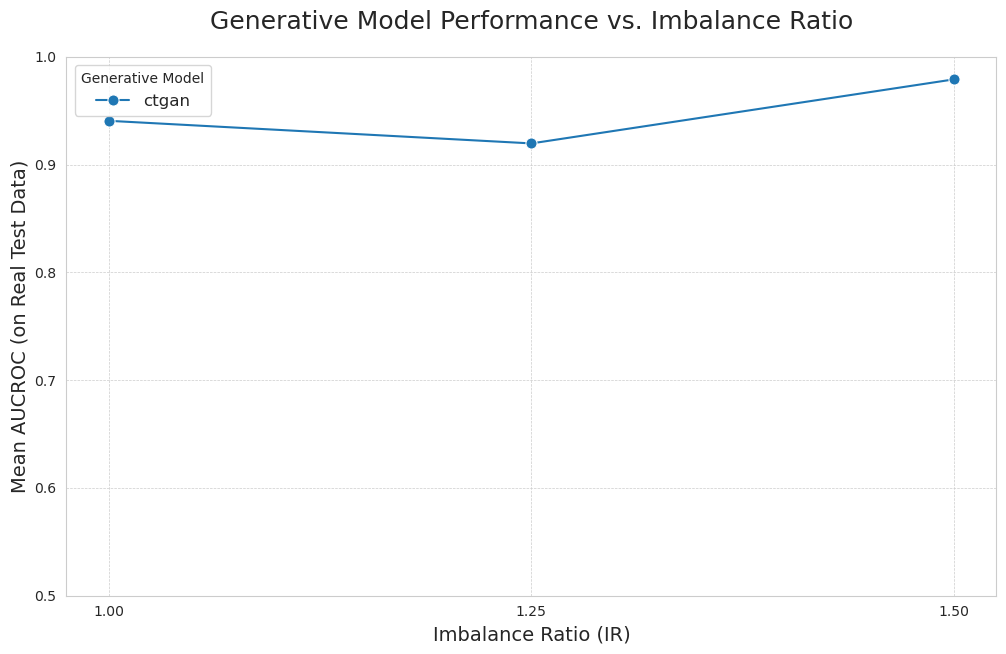

In [49]:
plt.figure(figsize=(12, 7))

sns.lineplot(
    data=results_df,
    x='ir',
    y='mean_aucroc',
    hue='model',
    marker='o',
    style='model',
    markersize=8
)

plt.title('Generative Model Performance vs. Imbalance Ratio', fontsize=18, pad=20)
plt.xlabel('Imbalance Ratio (IR)', fontsize=14)
plt.ylabel('Mean AUCROC (on Real Test Data)', fontsize=14)
plt.legend(title='Generative Model', fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(IMBALANCE_RATIOS)
plt.ylim(0.5, 1.0) 
plt.show()